This project is a simple exploration of works by Plato. 

The goal of the exploration is theoretically to analyze Plato's works to find the one that is most similar to "The Symposium." However, more than that, the goal is to exhibit basic capabilities of a text analysis using nltk and spaCy.

All texts were downloaded from the source below and underwent some cleaning before use in this project.

source: http://classics.mit.edu/Browse/index-Plato.html

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import os
import glob
import nltk
import spacy
from wordcloud import WordCloud

from gensim import corpora
from gensim.models import TfidfModel
from gensim import similarities

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from scipy.cluster import hierarchy

from itertools import chain



## Loading of Data

In [2]:
folder_republic = 'republic_chapters/'
folder_texts = 'plato_texts/'

files_republic = glob.glob(folder_republic + '*.txt')
files_texts = glob.glob(folder_texts + '*.txt')
files_republic.sort()
files_texts.sort()

republic = []
republic_titles = []
texts = []
texts_titles = []

for n in files_republic:
    f = open(n, encoding='utf-8-sig')
    data = re.sub('[\W]+', ' ', f.read())
    republic.append(data)
    republic_titles.append(os.path.basename(n).replace('.txt', ''))
    
for n in files_texts:
    f = open(n, encoding='utf-8-sig')
    data = re.sub('[\W]+', ' ', f.read())
    texts.append(data)
    texts_titles.append(os.path.basename(n).replace('.txt', ''))

    
    

In [3]:
# нахождение индексов одной работы по списку для дальнейшего анализа/сравнения
for i in range(len(republic)):
    if republic_titles[i] == 'republic_1':
        republic_index = i

for i in range(len(texts)):
    if texts_titles[i] == 'symposium':
        symposium_index = i
    
    
print(f'Index of first chapter of "The Republic" : {republic_index}')
print(f'Index of text "The Symposium" : {symposium_index}')

Index of first chapter of "The Republic" : 0
Index of text "The Symposium" : 20


In [4]:
stop_words = set(stopwords.words('english'))

texts_words = [[word_tokenize(sent) for sent in sent_tokenize(t.lower())] for t in texts]


In [5]:
length_dict = {}   
for txt, title in zip(texts_words, texts_titles):
    length_dict[title] = len(txt[0]) 
display(pd.DataFrame.from_dict(length_dict, orient='index', columns=['words']))


words
apology         11436
charmides       10672
cratylus        18753
critias          6783
crito            5362
euthydemus      15700
euthyfro         6801
gorgias         19210
ion              5177
laches          10296
lysis            9200
meno            12816
parmenides      19034
phaedo          19159
phaedrus        23119
philebus        18623
protagoras      19153
seventh_letter  13589
sophist         18501
stateman        18778
symposium       19202
theatu          18883
timaeus         32287

### Unnesting lists

In [6]:
print(len(texts_words[0][0]))
print(len(texts_words[0]))

11436
1


In [7]:
for i in range(len(texts_words)):
    texts_words[i] = list(pd.core.common.flatten(texts_words[i]))
    print(len(texts_words[i]))

11436
10672
18753
6783
5362
15700
6801
19210
5177
10296
9200
12816
19034
19159
23119
18623
19153
13589
18501
18778
19202
18883
32287


### Deletion of stopwords

In [8]:
length_dict = {}   

for i, title in zip(range(len(texts_words)), texts_titles):
    texts_words[i] = [w for w in texts_words[i] if w not in stop_words]
    length_dict[title] = len(texts_words[i])

display(pd.DataFrame.from_dict(length_dict, orient='index', columns=['words']))

words
apology          4408
charmides        4165
cratylus         8207
critias          2962
crito            2128
euthydemus       6284
euthyfro         2751
gorgias          7884
ion              2216
laches           4200
lysis            3617
meno             5380
parmenides       6899
phaedo           7726
phaedrus         9825
philebus         8379
protagoras       7814
seventh_letter   5760
sophist          8008
stateman         8236
symposium        8004
theatu           7936
timaeus         14013

### Lemmatization

In [9]:
wnl = WordNetLemmatizer()

for i in range(len(texts_words)):
    print(texts_words[i][20:25])
    texts_words[i] = [wnl.lemmatize(w) for w in texts_words[i]]
    print(texts_words[i][20:25])

['effect', 'yet', 'hardly', 'spoken', 'word']
['effect', 'yet', 'hardly', 'spoken', 'word']
['yesterday', 'evening', 'returned', 'army', 'potidaea']
['yesterday', 'evening', 'returned', 'army', 'potidaea']
['friend', 'cratylus', 'arguing', 'names', 'says']
['friend', 'cratylus', 'arguing', 'name', 'say']
['journey', 'may', 'rest', 'pray', 'always']
['journey', 'may', 'rest', 'pray', 'always']
['yes', 'certainly', 'soc', 'exact', 'time']
['yes', 'certainly', 'soc', 'exact', 'time']
['yesterday', 'lyceum', 'crowd', 'around', 'could']
['yesterday', 'lyceum', 'crowd', 'around', 'could']
['surely', 'concerned', 'suit', 'king', 'like']
['surely', 'concerned', 'suit', 'king', 'like']
['late', 'fray', 'feast', 'socrates', 'late']
['late', 'fray', 'feast', 'socrates', 'late']
['asclepius', 'soc', 'epidaurians', 'contests', 'rhapsodes']
['asclepius', 'soc', 'epidaurians', 'contest', 'rhapsodes']
['exhibition', 'man', 'fighting', 'armour', 'nicias']
['exhibition', 'man', 'fighting', 'armour', 'ni

### Creation of BOW and corpus for tfidf

In [10]:
texts_dict = corpora.Dictionary(texts_words)
texts_bows = [texts_dict.doc2bow(doc) for doc in texts_words]

In [11]:
df_bow_symposium = pd.DataFrame(texts_bows[symposium_index])

df_bow_symposium.columns = ['index', 'occurrences']

df_bow_symposium["token"] = [texts_dict[index] for index in df_bow_symposium['index']]

display(df_bow_symposium.sort_values(by='occurrences', ascending=False).head(10))

index  occurrences     token
384     786          233      love
566    1127          137      said
452     900          115       one
733    1437           81     would
276     578           73       god
603    1203           72  socrates
569    1132           66       say
280     583           62      good
1007   2121           60   agathon
399     812           59       men

WordCloud of most common terms in: APOLOGY


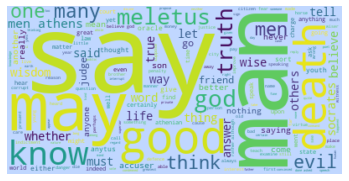

WordCloud of most common terms in: CHARMIDES


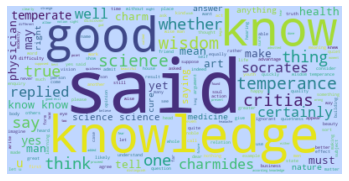

WordCloud of most common terms in: CRATYLUS


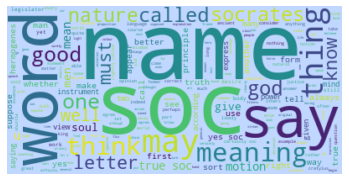

WordCloud of most common terms in: CRITIAS


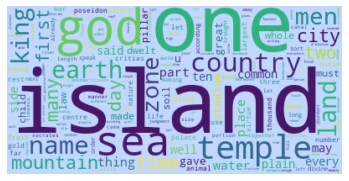

WordCloud of most common terms in: CRITO


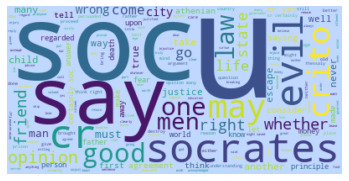

WordCloud of most common terms in: EUTHYDEMUS


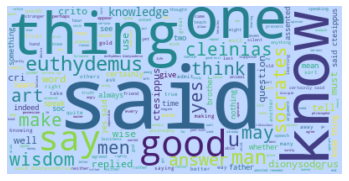

WordCloud of most common terms in: EUTHYFRO


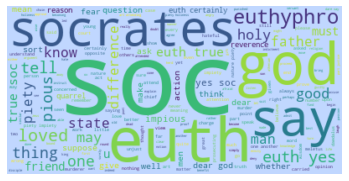

WordCloud of most common terms in: GORGIAS


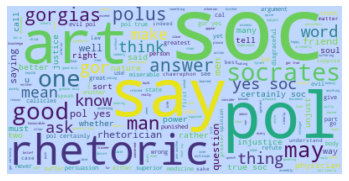

WordCloud of most common terms in: ION


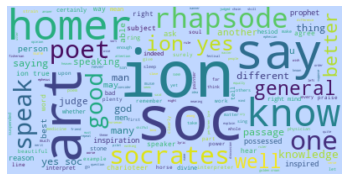

WordCloud of most common terms in: LACHES


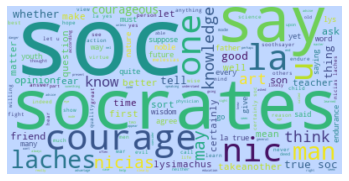

WordCloud of most common terms in: LYSIS


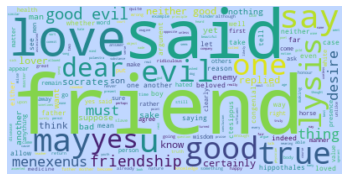

WordCloud of most common terms in: MENO


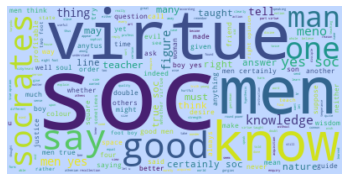

WordCloud of most common terms in: PARMENIDES


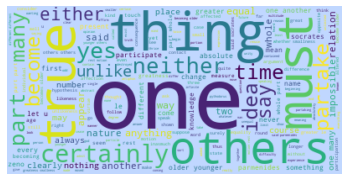

WordCloud of most common terms in: PHAEDO


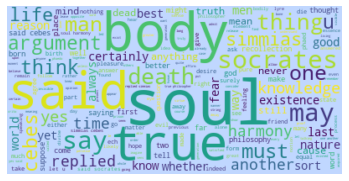

WordCloud of most common terms in: PHAEDRUS


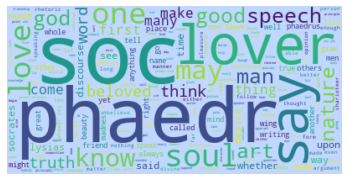

WordCloud of most common terms in: PHILEBUS


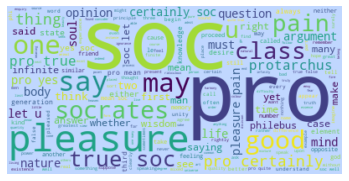

WordCloud of most common terms in: PROTAGORAS


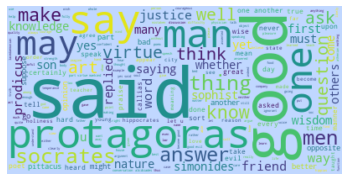

WordCloud of most common terms in: SEVENTH_LETTER


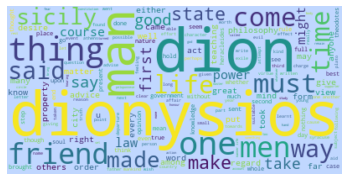

WordCloud of most common terms in: SOPHIST


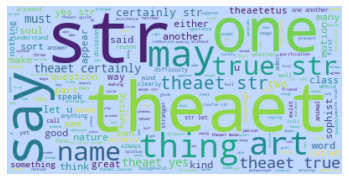

WordCloud of most common terms in: STATEMAN


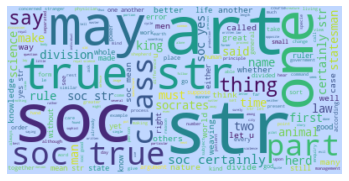

WordCloud of most common terms in: SYMPOSIUM


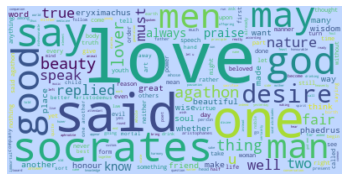

WordCloud of most common terms in: THEATU


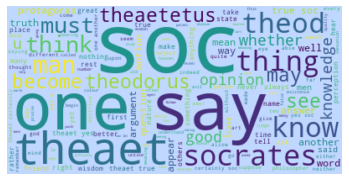

WordCloud of most common terms in: TIMAEUS


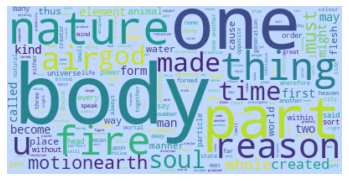

In [12]:
for title, txt in zip(texts_titles, range(len(texts_words))):
    print(f'WordCloud of most common terms in: {title.upper()}')
    wordcloud = WordCloud(background_color='#C0D7FF').generate(' '.join(w for w in texts_words[txt]))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [13]:
model = TfidfModel(texts_bows)
symposium_vector = model[texts_bows[symposium_index]]

In [14]:
symposium_tfidf = pd.DataFrame(symposium_vector)

symposium_tfidf.columns = ['id', 'score']

symposium_tfidf['token']= df_bow_symposium['token']

display(symposium_tfidf.sort_values(by='score', ascending=False).head(15))


id     score         token
909   2121  0.592570       outward
1717  6959  0.266656       section
1869  9024  0.212842   expectation
1741  7221  0.207399      youngest
46     108  0.153948     appearing
1939  9094  0.136827        fuller
1348  4315  0.118738     meanwhile
1800  7913  0.106579        begets
482   1087  0.099590         piety
1994  9149  0.091218      ceremony
1310  4162  0.079009       fairest
2102  9257  0.076015  immeasurable
674   1512  0.075663    translated
783   1791  0.073904        circle
937   2256  0.072693       related

In [15]:
sims = similarities.MatrixSimilarity(model[texts_bows])

sim_df = pd.DataFrame(list(sims))

sim_df.index = texts_titles
sim_df.columns = texts_titles

display(sim_df)

apology  charmides  cratylus   critias     crito  euthydemus  \
apology         1.000000   0.026489  0.032922  0.023163  0.043905    0.022775   
charmides       0.026489   1.000000  0.017677  0.069881  0.006536    0.024704   
cratylus        0.032922   0.017677  1.000000  0.033657  0.070030    0.039226   
critias         0.023163   0.069881  0.033657  1.000000  0.009394    0.015880   
crito           0.043905   0.006536  0.070030  0.009394  1.000000    0.046888   
euthydemus      0.022775   0.024704  0.039226  0.015880  0.046888    1.000000   
euthyfro        0.040347   0.007012  0.081697  0.006115  0.018218    0.008291   
gorgias         0.021268   0.011197  0.094659  0.006612  0.030180    0.017340   
ion             0.011276   0.006511  0.136977  0.009295  0.018961    0.015449   
laches          0.013695   0.016335  0.071007  0.007917  0.020472    0.013713   
lysis           0.023734   0.030594  0.017294  0.020274  0.007999    0.078049   
meno            0.064475   0.031430  0.286697  0.018419  0.075907    0.037000   
parmenides      0.022029   0.020719  0.036233  0.024499  0.008761    0.012431   
phaedo          0.055183   0.044560  0.035801  0.021615  0.047810    0.031795   
phaedrus        0.022954   0.017916  0.084466  0.023317  0.022755    0.018446   
philebus        0.004522   0.005436  0.073211  0.004450  0.018358    0.007426   
protagoras      0.053846   0.083865  0.062073  0.043633  0.019117    0.043651   
seventh_letter  0.035714   0.016156  0.025802  0.023256  0.012157    0.008366   
sophist         0.003608   0.004195  0.006423  0.003977  0.001350    0.003141   
stateman        0.010532   0.022828  0.098205  0.017337  0.025029    0.012823   
symposium       0.051974   0.059469  0.068480  0.051477  0.016964    0.032866   
theatu          0.020367   0.019072  0.136527  0.016365  0.034001    0.018260   
timaeus         0.042435   0.060163  0.100833  0.141243  0.015505    0.018215   

                euthyfro   gorgias       ion    laches  ...    phaedo  \
apology         0.040347  0.021268  0.011276  0.013695  ...  0.055183   
charmides       0.007012  0.011197  0.006511  0.016335  ...  0.044560   
cratylus        0.081697  0.094659  0.136977  0.071007  ...  0.035801   
critias         0.006115  0.006612  0.009295  0.007917  ...  0.021615   
crito           0.018218  0.030180  0.018961  0.020472  ...  0.047810   
euthydemus      0.008291  0.017340  0.015449  0.013713  ...  0.031795   
euthyfro        1.000000  0.025245  0.019888  0.018707  ...  0.005591   
gorgias         0.025245  1.000001  0.027646  0.026775  ...  0.009174   
ion             0.019888  0.027646  1.000000  0.021296  ...  0.008177   
laches          0.018707  0.026775  0.021296  1.000000  ...  0.010839   
lysis           0.015706  0.006924  0.006943  0.006273  ...  0.033199   
meno            0.072796  0.112571  0.082528  0.082989  ...  0.020208   
parmenides      0.004135  0.007948  0.005242  0.005314  ...  0.041600   
phaedo          0.005591  0.009174  0.008177  0.010839  ...  1.000000   
phaedrus        0.021083  0.043572  0.027478  0.022028  ...  0.024218   
philebus        0.017957  0.025902  0.020044  0.018938  ...  0.010234   
protagoras      0.017340  0.019775  0.016561  0.028406  ...  0.044864   
seventh_letter  0.006860  0.005764  0.002810  0.006530  ...  0.019956   
sophist         0.000944  0.001787  0.001434  0.001625  ...  0.005293   
stateman        0.024202  0.033417  0.026698  0.025439  ...  0.009706   
symposium       0.009651  0.017513  0.017826  0.013665  ...  0.069238   
theatu          0.031149  0.045691  0.036654  0.034505  ...  0.020221   
timaeus         0.008123  0.015974  0.013400  0.014080  ...  0.095915   

                phaedrus  philebus  protagoras  seventh_letter   sophist  \
apology         0.022954  0.004522    0.053846        0.035714  0.003608   
charmides       0.017916  0.005436    0.083865        0.016156  0.004195   
cratylus        0.084466  0.073211    0.062073        0.025802  0.006423   
critias        

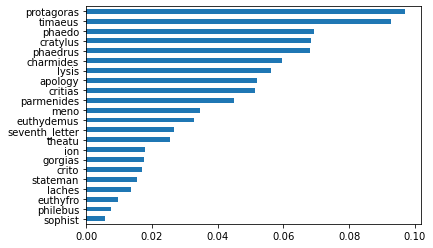

In [16]:
symposium_comp = sim_df.iloc[symposium_index]

symposium_comp_sorted = symposium_comp.drop('symposium').sort_values(ascending=True)

symposium_comp_sorted.plot.barh(x='title', y='similarity')

plt.show()

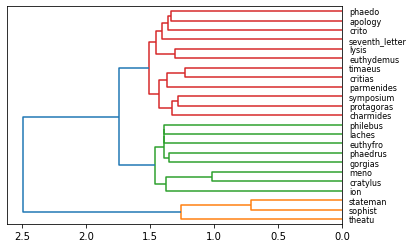

In [17]:
Z = hierarchy.linkage(sim_df, 'ward')

a = hierarchy.dendrogram(Z, leaf_font_size=8, labels=sim_df.index, orientation='left')

This experiment has yielded some interesting results, but they cannot be trusted with sufficient certainty.

The reason for this can be seen in the wordclouds of the different works. Many words of the most frequently occuring words do not give us information about the focus of the text. For example, "Soc" does not tell us anything beyond the fact that Socrates speaks a significant number of times in that text. Other examples of such words include "say," "must," and "replied." There are also words that are debatedly important, such as "think" and "know," "true" and "great."

There are multiple approaches to addressing this question.

One would be to compile a list of words that can be considered unnecessary, then to remove them before comparing the texts.

Another would be to use a more complex NLP tool, like spaCy, to tag the words, then to remove them based on certain criteria. For example, if the primary concern is conceptual content, it would likely make sense to remove all character names. This approach might still require a separate list of words to be removed after removing character names.

Additionally, it would very likely be useful to do a comparison of the texts on the basis of bigrams, as this might help filter out common vocab and leave common conceptually important phrases. For example, a high tfidf score of the word "good" gives very little information, but a high tfidf score of "the good" might offer more information about the text (though not necessarily, as this could be simply an article and an adjective, rather than a deeper concept about the idea of the good).



## spaCy approach

In [18]:
nlp = spacy.load('en_core_web_sm')
# republic_docs = []
texts_docs = []
for text in texts:
    texts_docs.append(nlp(text))
    

In [19]:
for doc in texts_docs:
    for token in doc[30:50]:
        print(f'{token.lemma_:<20}{token.text:<20}{token.pos_:<20}{token.dep_:<20}')

know                know                VERB                ROOT                
that                that                SCONJ               mark                
their               their               PRON                poss                
persuasive          persuasive          ADJ                 amod                
word                words               NOUN                nsubj               
almost              almost              ADV                 advmod              
make                made                VERB                ccomp               
I                   me                  PRON                nsubj               
forget              forget              VERB                ccomp               
who                 who                 PRON                attr                
I                   I                   PRON                nsubj               
be                  was                 AUX                 ccomp               
such                such    

In [20]:
for doc in texts_docs:
    counter = 0
    counter += 1
    if counter <= 10:
        for ent in doc.ents:
            print(f'{ent.text:<20}{ent.label_:<20}')

Plato Translated    ORG                 
Benjamin Jowett SocratesPERSON              
Athens              GPE                 
Athens              GPE                 
one                 CARDINAL            
more than seventy years of ageDATE                
first               ORDINAL             
first               ORDINAL             
first               ORDINAL             
many years          DATE                
Anytus              ORG                 
one                 CARDINAL            
two                 CARDINAL            
Meletus             ORG                 
Aristophanes        NORP                
Speak               GPE                 
Leontium            GPE                 
Hippias of Elis     PERSON              
Parian              NORP                
Athens              GPE                 
Sophists            NORP                
Callias             PERSON              
two                 CARDINAL            
Parian              NORP                
fi

Dionysodorus        PERSON              
two                 CARDINAL            
Zeus                PERSON              
Crito               PERSON              
Dionysodorus        PERSON              
Dionysodorus        PERSON              
Dionysodorus        PERSON              
Dionysodorus        PERSON              
one                 CARDINAL            
two                 CARDINAL            
Heracles            PERSON              
Heracles            PERSON              
Hydra               GPE                 
second              ORDINAL             
Sophist             ORG                 
Iolaus              PERSON              
Dionysodorus        PERSON              
Iolaus              PERSON              
Heracles            PERSON              
Dionysodorus        PERSON              
Iolaus              PERSON              
Heracles            PERSON              
Iphicles            PERSON              
Heracles            PERSON              
Chaeredemus     

Gorgias             PERSON              
Herodicus           PERSON              
Pol Certainly Chaer PERSON              
Chaer               PERSON              
Aristophon          DATE                
Pol Clearly         PERSON              
Chaer               PERSON              
Pol O Chaerephon    PERSON              
the days            DATE                
Gorgias             PERSON              
Soc Polus           PERSON              
Gorgias             PERSON              
Gor                 PERSON              
Gor                 PERSON              
Polus               PRODUCT             
Pol                 PERSON              
Polus               PRODUCT             
Gorgias             PERSON              
Pol Why             PERSON              
Gorgias             PERSON              
first               ORDINAL             
Gorgias Or          PERSON              
Gor Rhetoric SocratesPERSON              
Gor                 PERSON              
Gor            

two                 CARDINAL            
three feet          QUANTITY            
three feet          QUANTITY            
three               CARDINAL            
three               CARDINAL            
three feet          QUANTITY            
four                CARDINAL            
eight               CARDINAL            
three               CARDINAL            
first               ORDINAL             
eight feet          QUANTITY            
Soc Mark            PERSON              
four feet           QUANTITY            
third               ORDINAL             
Boy Very            PERSON              
four                CARDINAL            
Four                CARDINAL            
Boy True Soc        PERSON              
four                CARDINAL            
half                CARDINAL            
four                CARDINAL            
Four                CARDINAL            
Two                 CARDINAL            
four                CARDINAL            
two             

daily               DATE                
Hellas              GPE                 
Cebes               GPE                 
two                 CARDINAL            
two                 CARDINAL            
Cebes               GPE                 
the season of the yearDATE                
Egypt               GPE                 
Simmias             PERSON              
Cebes               GPE                 
Simmias             PERSON              
Cebes               GPE                 
one                 CARDINAL            
Socrates            ORG                 
Cebes Why           PERSON              
Cebes               GPE                 
Penelope            LOC                 
Cebes               GPE                 
Cebes               GPE                 
Simmias             PERSON              
Simmias             PERSON              
Socrates            PRODUCT             
swans               NORP                
Apollo              ORG                 
that day      

Protagoras          PERSON              
Protagoras          PERSON              
Pericles            ORG                 
Protagoras          PERSON              
Protagoras          PERSON              
one                 CARDINAL            
Zeus                PERSON              
one                 CARDINAL            
first               ORDINAL             
first               ORDINAL             
Mine                ORG                 
Protagoras          PERSON              
Protagoras          PERSON              
Protagoras          PERSON              
Protagoras          PERSON              
one                 CARDINAL            
First               ORDINAL             
more than one       CARDINAL            
Protagoras          PERSON              
two                 CARDINAL            
one                 CARDINAL            
two                 CARDINAL            
only one            CARDINAL            
more than one       CARDINAL            
two             

Theaetetus          ORG                 
three               CARDINAL            
Sophists            NORP                
Sophists            NORP                
Theaet Indeed       WORK_OF_ART         
Shall               PERSON              
Str                 PERSON              
two                 CARDINAL            
Theaet              WORK_OF_ART         
Str Seeing          PERSON              
Str                 PERSON              
two                 CARDINAL            
Theaet              WORK_OF_ART         
Str                 ORG                 
Theaet How Str Open WORK_OF_ART         
Theaet              WORK_OF_ART         
Str Into            ORG                 
Str                 PERSON              
two                 CARDINAL            
Theaet True Str     WORK_OF_ART         
one                 CARDINAL            
Theaet Certainly Str FowlingWORK_OF_ART         
two                 CARDINAL            
one                 CARDINAL            
Str     

Socrates            PRODUCT             
first               ORDINAL             
Apollodorus         GPE                 
Socrates ApollodorusWORK_OF_ART         
Com No              PERSON              
Apollodorus         GPE                 
Agathon             ORG                 
yesterday           DATE                
Menelaus            PERSON              
Socrates            ORG                 
Menelaus            PERSON              
Two                 CARDINAL            
one                 CARDINAL            
Socrates            PRODUCT             
Agathon             PERSON              
Agathon             PERSON              
yesterday           DATE                
Socrates            PRODUCT             
Agathon             PERSON              
Agathon             PERSON              
Agathon             PERSON              
Agathon             ORG                 
about half          CARDINAL            
Agathon             PERSON              
the day before y

Theaet Indeed SocratesWORK_OF_ART         
two                 CARDINAL            
one half            CARDINAL            
half                CARDINAL            
Theaet Certainly SocWORK_OF_ART         
Theaet              WORK_OF_ART         
Theaet Certainly    ORG                 
Theaet Certainly Soc WereWORK_OF_ART         
Socrates            PRODUCT             
Socrates            PRODUCT             
Theaet              WORK_OF_ART         
Theaet Certainly SocWORK_OF_ART         
Theaet              WORK_OF_ART         
two                 CARDINAL            
Theaet Certainly SocWORK_OF_ART         
Theaet Certainly    WORK_OF_ART         
Theaet True Soc     WORK_OF_ART         
Theaet Certainly not Soc WhenWORK_OF_ART         
Theaet Very true Socrates SocWORK_OF_ART         
Protagoras          PERSON              
Theaet You          WORK_OF_ART         
Protagoras          PERSON              
first               ORDINAL             
Theod Theaetetus    ORG         

Looking at the information yielded by spaCy, several thoughts come to mind:

- it likely would make more sense to take a white-list approach to filtering information, rather than excluding information (for example, including only nouns)
- in the list of entities, many characters (especially the abbreviations of their names) are listed as organizations, thus organizations should also be excluded if entities are to be used for analysis


WordCloud of most common terms in: APOLOGY


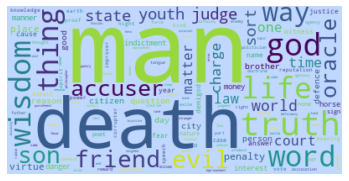

WordCloud of most common terms in: CHARMIDES


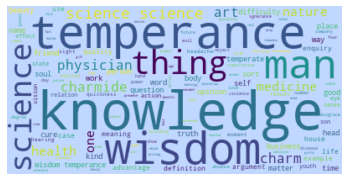

WordCloud of most common terms in: CRATYLUS


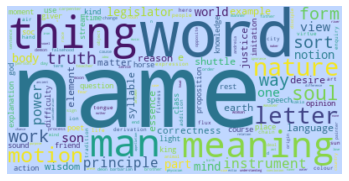

WordCloud of most common terms in: CRITIAS


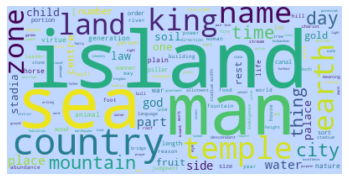

WordCloud of most common terms in: CRITO


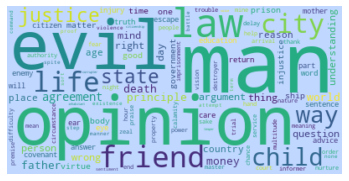

WordCloud of most common terms in: EUTHYDEMUS


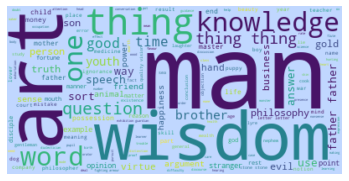

WordCloud of most common terms in: EUTHYFRO


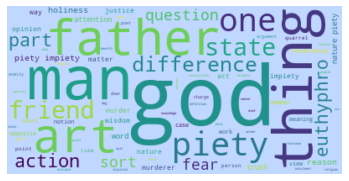

WordCloud of most common terms in: GORGIAS


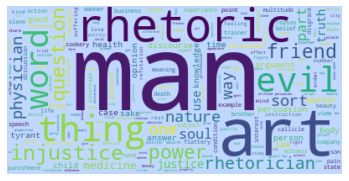

WordCloud of most common terms in: ION


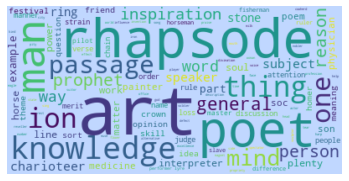

WordCloud of most common terms in: LACHES


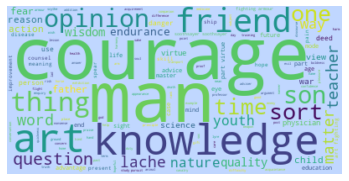

WordCloud of most common terms in: LYSIS


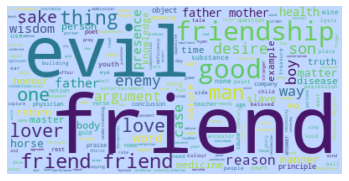

WordCloud of most common terms in: MENO


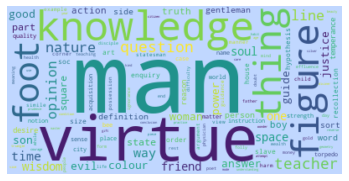

WordCloud of most common terms in: PARMENIDES


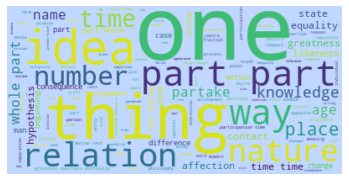

WordCloud of most common terms in: PHAEDO


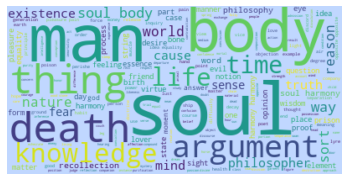

WordCloud of most common terms in: PHAEDRUS


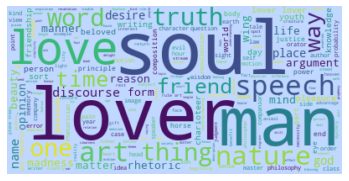

WordCloud of most common terms in: PHILEBUS


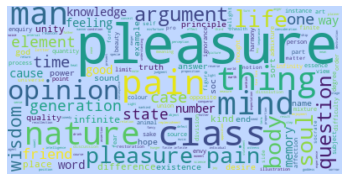

WordCloud of most common terms in: PROTAGORAS


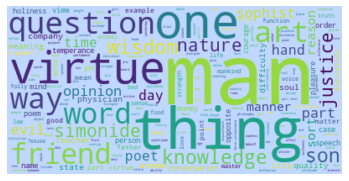

WordCloud of most common terms in: SEVENTH_LETTER


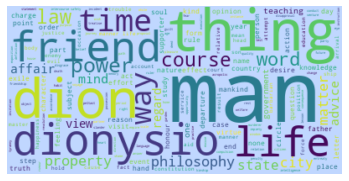

WordCloud of most common terms in: SOPHIST


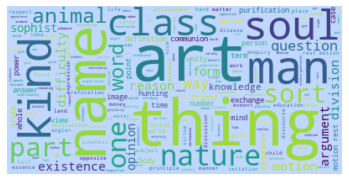

WordCloud of most common terms in: STATEMAN


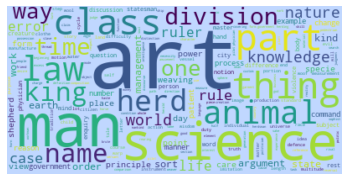

WordCloud of most common terms in: SYMPOSIUM


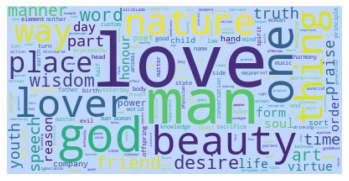

WordCloud of most common terms in: THEATU


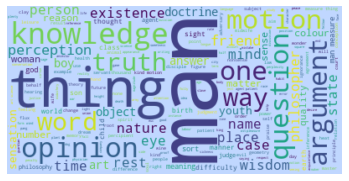

WordCloud of most common terms in: TIMAEUS


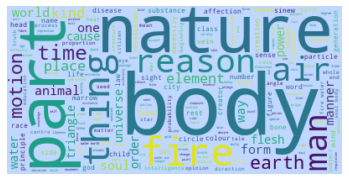

In [21]:
for title, txt in zip(texts_titles, range(len(texts))):
    print(f'WordCloud of most common terms in: {title.upper()}')
    words = ' '.join(token.lemma_ for token in texts_docs[txt] if token.pos_ == 'NOUN')
    wordcloud = WordCloud(background_color='#C0D7FF').generate(words)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

This set of wordclouds looks significantly different (and more promising) than the first set.

In [22]:
texts_words =[[token.lemma_ for token in doc if token.pos_ == 'NOUN'] for doc in texts_docs]
texts_dict = corpora.Dictionary(texts_words)
texts_bows = [texts_dict.doc2bow(doc) for doc in texts_words]

In [23]:
model = TfidfModel(texts_bows)

sims = similarities.MatrixSimilarity(model[texts_bows])

sim_df = pd.DataFrame(list(sims))

sim_df.index = texts_titles
sim_df.columns = texts_titles

display(sim_df)

apology  charmides  cratylus   critias     crito  euthydemus  \
apology         1.000000   0.023654  0.051063  0.026035  0.142175    0.082012   
charmides       0.023654   1.000000  0.022521  0.018958  0.019621    0.081852   
cratylus        0.051063   0.022521  1.000000  0.035655  0.035641    0.074109   
critias         0.026035   0.018958  0.035655  1.000001  0.032495    0.053711   
crito           0.142175   0.019621  0.035641  0.032495  1.000000    0.054012   
euthydemus      0.082012   0.081852  0.074109  0.053711  0.054012    1.000000   
euthyfro        0.081612   0.025277  0.021042  0.018723  0.032058    0.041313   
gorgias         0.072573   0.031996  0.034327  0.020739  0.101929    0.116884   
ion             0.030976   0.015155  0.066265  0.018637  0.004959    0.056339   
laches          0.072847   0.076545  0.035786  0.025607  0.051060    0.136323   
lysis           0.046694   0.046694  0.037733  0.040518  0.045379    0.111427   
meno            0.045911   0.080383  0.040380  0.039080  0.034836    0.099358   
parmenides      0.021687   0.015494  0.044334  0.029025  0.020698    0.031601   
phaedo          0.089634   0.081296  0.078509  0.028276  0.094781    0.084852   
phaedrus        0.082704   0.066408  0.091766  0.075002  0.069068    0.176018   
philebus        0.045419   0.053135  0.068213  0.029738  0.030358    0.060434   
protagoras      0.066872   0.096268  0.046470  0.045794  0.078678    0.112835   
seventh_letter  0.055925   0.021788  0.043651  0.026004  0.061070    0.041999   
sophist         0.039356   0.057629  0.092525  0.040229  0.042145    0.140627   
stateman        0.062424   0.156740  0.092778  0.071850  0.067883    0.101282   
symposium       0.076824   0.090784  0.069842  0.058968  0.064586    0.131685   
theatu          0.083242   0.073696  0.117005  0.050068  0.074482    0.122918   
timaeus         0.049866   0.029363  0.099474  0.117370  0.037931    0.056374   

                euthyfro   gorgias       ion    laches  ...    phaedo  \
apology         0.081612  0.072573  0.030976  0.072847  ...  0.089634   
charmides       0.025277  0.031996  0.015155  0.076545  ...  0.081296   
cratylus        0.021042  0.034327  0.066265  0.035786  ...  0.078509   
critias         0.018723  0.020739  0.018637  0.025607  ...  0.028276   
crito           0.032058  0.101929  0.004959  0.051060  ...  0.094781   
euthydemus      0.041313  0.116884  0.056339  0.136323  ...  0.084852   
euthyfro        1.000000  0.028427  0.013294  0.034478  ...  0.028740   
gorgias         0.028427  1.000000  0.019167  0.040458  ...  0.059191   
ion             0.013294  0.019167  1.000000  0.020500  ...  0.023816   
laches          0.034478  0.040458  0.020500  1.000000  ...  0.069531   
lysis           0.031060  0.044920  0.035957  0.052405  ...  0.089979   
meno            0.032561  0.041476  0.030084  0.080948  ...  0.087777   
parmenides      0.009883  0.023796  0.008069  0.017895  ...  0.083613   
phaedo          0.028740  0.059191  0.023816  0.069531  ...  1.000000   
phaedrus        0.041781  0.325892  0.085376  0.061148  ...  0.160676   
philebus        0.018255  0.050353  0.013956  0.053409  ...  0.194401   
protagoras      0.084813  0.067285  0.035851  0.091224  ...  0.093770   
seventh_letter  0.050968  0.029467  0.006450  0.033534  ...  0.046003   
sophist         0.034350  0.061272  0.025283  0.061479  ...  0.131713   
stateman        0.072079  0.052603  0.031725  0.066545  ...  0.076678   
symposium       0.042372  0.084244  0.044092  0.071023  ...  0.167801   
theatu          0.050358  0.085033  0.032048  0.060786  ...  0.112445   
timaeus         0.012702  0.035530  0.020210  0.033308  ...  0.203845   

                phaedrus  philebus  protagoras  seventh_letter   sophist  \
apology         0.082704  0.045419    0.066872        0.055925  0.039356   
charmides       0.066408  0.053135    0.096268        0.021788  0.057629   
cratylus        0.091766  0.068213    0.046470        0.043651  0.092525   
critias        

Works that are most similar to "The Symposium":


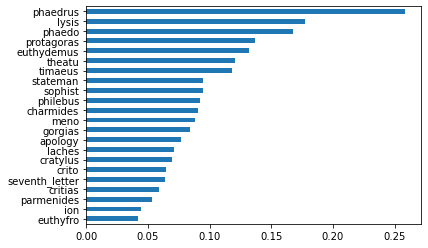

In [24]:
symposium_comp = sim_df.iloc[symposium_index]

symposium_comp_sorted = symposium_comp.drop('symposium').sort_values(ascending=True)

symposium_comp_sorted.plot.barh(x='title', y='similarity')

print('Works that are most similar to "The Symposium":')
plt.show()

It is clear from the similarity values that the exclusive use of nouns has provided better results than the use of all words. The max similarity score in the second analysis is more than twice that of the previous max similarity score. That being said, the scores are not extremely high. For the purposes of this exploration, they are sufficiently high to deem the approach satisfactory, but a more in-depth analysis would require further work on the data before comparison.

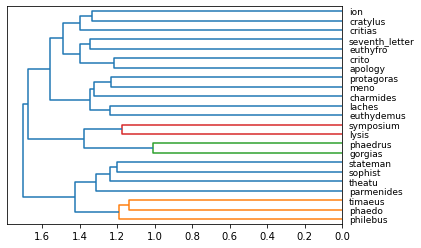

In [25]:
Z = hierarchy.linkage(sim_df, 'ward')

a = hierarchy.dendrogram(Z, leaf_font_size=9, labels=sim_df.index, orientation='left')

While this approach to Plato's texts has not been rigourous, it has clearly highlighted some important points for any more in-depth comparisons of texts.

First, it has highlighted the importance of a goal-conscious approach to analysis.

Here, I was interested in doing a preliminary comparison of the concepts discussed in Plato's texts. As such, I chose to include only those words that were tagged as 'NOUN' (which does not include people, who would be listed as 'PROPN,' if marked correctly). This approach was sufficient for my current goals, but on the whole has drawbacks. One could come up with a variety of reasons for which this approach is insufficient; to name one example, one could look at the concept of "the Athenian." In a given text, the discussion of the virtues/responsibilities/etc. of an Athenian may differ both in purpose and in content from a discussion of virtue/responsibility/etc. by itself. However, with my approach, the word "Athenian" was excluded from the lists used to compare the texts.

To name one example of a different goal that would influence the required approach to textual analysis, one could give the example of the comparison of writing styles between authors. For example, if my aim were to find authors whose style was similar to that of, for example, Oscar Wilde, the removal of adjectives and adverbs from the comparative process would be an egregious error. Similarly, if my goal were to find 'the modern Wilde,' then it might make more sense to compare the diversity of the lexicon employed by the author to that of modern authors, rather than the words or phrases themselves, many of which have likely become less common over time.


Second, to reiterate a previously mentioned point, the use of unigrams alone seems insufficient. I would likely make the same comment for any language, but specifically the English language overflows with meaning-changing combinations of words, with phrasal verbs being a prime example of the phenomenon. Beyond this, there is simply more information to be gleaned from combinations such as "the virtuous life" than from the individual words "virtuous" and "life."





## "The Republic" Chapters with spaCy

Given that the approach using spaCy's tagger has yielded satisfactory results for the purposes of this exploration, I will now repeat the process to compare the chapters from "The Republic." If the approach is indeed appropriate, then the similarity table should show relatively higher similarity scores. As for the dendrogram, it is harder to make a prediction as to its particular representation, but it should also reflect the conceptual similarity between the chapters.

In [26]:
nlp = spacy.load('en_core_web_sm')
republic_docs = []
# texts_docs = []
for chap in republic:
    republic_docs.append(nlp(chap))
    

In [27]:
for doc in republic_docs:
    for token in doc[30:50]:
        print(f'{token.lemma_:<20}{token.text:<20}{token.pos_:<20}{token.dep_:<20}')

I                   I                   PRON                nsubj               
want                wanted              VERB                conj                
to                  to                  PART                aux                 
see                 see                 VERB                xcomp               
in                  in                  ADP                 prep                
what                what                DET                 det                 
manner              manner              NOUN                pcomp               
they                they                PRON                nsubj               
would               would               AUX                 aux                 
celebrate           celebrate           VERB                ccomp               
the                 the                 DET                 det                 
festival            festival            NOUN                dobj                
which               which   

In [28]:
for doc in republic_docs:
    counter = 0
    counter += 1
    if counter <= 10:
        for ent in doc.ents:
            print(f'{ent.text:<20}{ent.label_:<20}')

yesterday           DATE                
Glaucon             ORG                 
Ariston             PERSON              
Thracians           NORP                
Polemarchus         GPE                 
Polemarchus         GPE                 
Glaucon             ORG                 
a few minutes       TIME                
Polemarchus         GPE                 
Socrates POLEMARCHUS GLAUCON ADEIMANTUS PolemarchusLAW                 
Glaucon             ORG                 
Adeimantus          ORG                 
Polemarchus         GPE                 
Glaucon             ORG                 
Polemarchus         GPE                 
Lysias              PERSON              
Paeanian            NORP                
Polemarchus         GPE                 
Cephalus            PRODUCT             
Sophocles           PRODUCT             
Sophocles           ORG                 
one                 CARDINAL            
Themistocles        ORG                 
Seriphian           NORP  

WordCloud of most common terms in: REPUBLIC_1


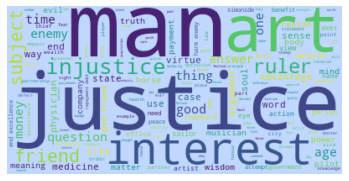

WordCloud of most common terms in: REPUBLIC_10


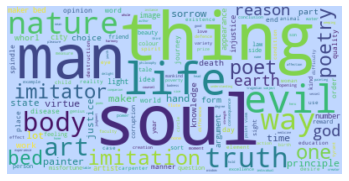

WordCloud of most common terms in: REPUBLIC_2


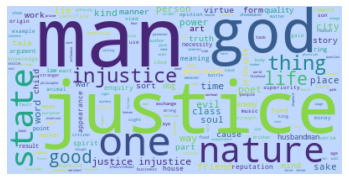

WordCloud of most common terms in: REPUBLIC_3


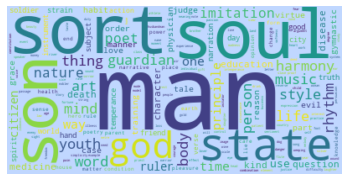

WordCloud of most common terms in: REPUBLIC_4


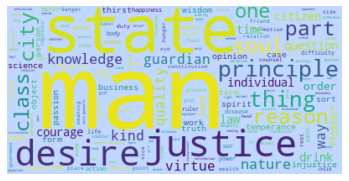

WordCloud of most common terms in: REPUBLIC_5


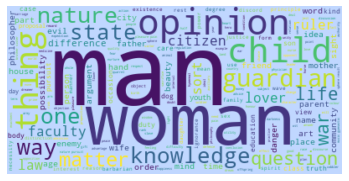

WordCloud of most common terms in: REPUBLIC_6


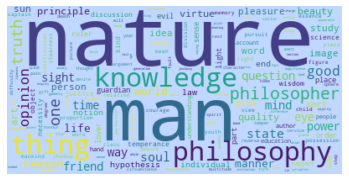

WordCloud of most common terms in: REPUBLIC_7


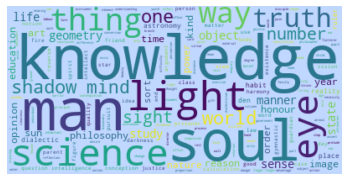

WordCloud of most common terms in: REPUBLIC_8


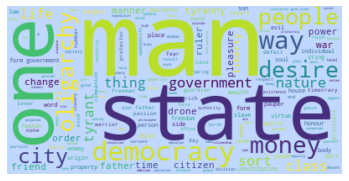

WordCloud of most common terms in: REPUBLIC_9


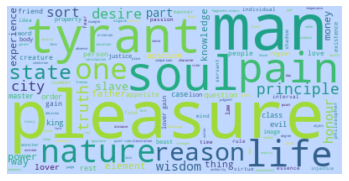

In [29]:
for title, chap in zip(republic_titles, range(len(republic))):
    print(f'WordCloud of most common terms in: {title.upper()}')
    words = ' '.join(token.lemma_ for token in republic_docs[chap] if token.pos_ == 'NOUN')
    wordcloud = WordCloud(background_color='#C0D7FF').generate(words)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [30]:
republic_words =[[token.lemma_ for token in doc if token.pos_ == 'NOUN'] for doc in republic_docs]
republic_dict = corpora.Dictionary(republic_words)
republic_bows = [republic_dict.doc2bow(doc) for doc in republic_words]


In [31]:
model = TfidfModel(republic_bows)

sims = similarities.MatrixSimilarity(model[republic_bows])

sim_df = pd.DataFrame(list(sims))

sim_df.index = republic_titles
sim_df.columns = republic_titles

display(sim_df)

republic_1  republic_10  republic_2  republic_3  republic_4  \
republic_1     1.000000     0.076795    0.121266    0.118739    0.090791   
republic_10    0.076795     1.000000    0.133132    0.152968    0.069740   
republic_2     0.121266     0.133132    1.000000    0.170772    0.117535   
republic_3     0.118739     0.152968    0.170772    1.000000    0.119232   
republic_4     0.090791     0.069740    0.117535    0.119232    1.000000   
republic_5     0.095402     0.068928    0.084589    0.107906    0.109447   
republic_6     0.090615     0.085191    0.091255    0.079030    0.107898   
republic_7     0.047338     0.058747    0.060472    0.066276    0.108827   
republic_8     0.082810     0.054044    0.052890    0.054550    0.059386   
republic_9     0.057151     0.085860    0.075755    0.073299    0.077773   

             republic_5  republic_6  republic_7  republic_8  republic_9  
republic_1     0.095402    0.090615    0.047338    0.082810    0.057151  
republic_10    0.068928    0.085191    0.058747    0.054044    0.085860  
republic_2     0.084589    0.091255    0.060472    0.052890    0.075755  
republic_3     0.107906    0.079030    0.066276    0.054550    0.073299  
republic_4     0.109447    0.107898    0.108827    0.059386    0.077773  
republic_5     1.000000    0.128577    0.079334    0.061813    0.072926  
republic_6     0.128577    1.000000    0.240523    0.048776    0.071294  
republic_7     0.079334    0.240523    1.000000    0.032188    0.062359  
republic_8     0.061813    0.048776    0.032188    0.999999    0.186950  
republic_9     0.072926    0.071294    0.062359    0.186950    1.000000

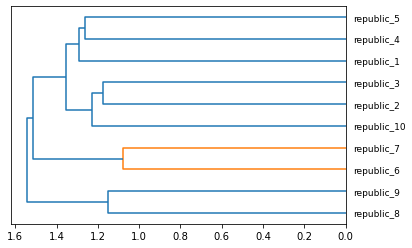

In [32]:
Z = hierarchy.linkage(sim_df, 'ward')

a = hierarchy.dendrogram(Z, leaf_font_size=9, labels=sim_df.index, orientation='left')

As expected, the similarity scores presented in the table are on average higher than those from the previous comparison of Plato's texts. That being said, barring certain combinations of chapters, they are still not particularly high. The reason for this may be in the length of the texts. The chapters in "The Republic" are significantly shorter than many of the works previously compared, and additionally there are fewer of them. Greater length of text and greater number of texts can lead to a smoothing effect for this kind of analysis. By this I mean that language, especially written language, will in any case present a certain diversity despite sharing a topic. In a shorter text, using a tfidf approach as is done here, any random nouns, for example those found in examples to demonstrate a point, will necessarily have a higher tfidf than the same example would have in a longer text (e.g. : one is talking about virtue and uses Achilles as an example; in a comparison of a few short texts, "Achilles" will have a higher tfidf score than in a comparison of a greater number of longer texts).